<a href="https://colab.research.google.com/github/Baeltor/PCD/blob/prog/NotebooksMLII/RNN_y_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción a las redes neuronales recurrentes LSTM y GRU
___

Sergio David Díaz Veru


## Redes neuronales recurrentes

En una red neuronal recurrente almacenamos las activaciones de salida de una o más capas de la red. A menudo, se trata de activaciones posteriores ocultas. Luego, la próxima vez que introducimos un ejemplo de entrada en la red, incluimos las salidas almacenadas previamente como entradas adicionales. Puede pensar en las entradas adicionales como si estuvieran concatenadas al final de las entradas "normales" de la capa anterior. Por ejemplo, si una capa oculta tuviera 10 nodos de entrada regulares y 128 nodos ocultos en la capa, entonces en realidad tendría 138 entradas en total (en lugar de en otra capa). Por supuesto, la primera vez que se intente calcular la salida de la red, deberá completar esas 128 entradas adicionales con 0 u otros valores

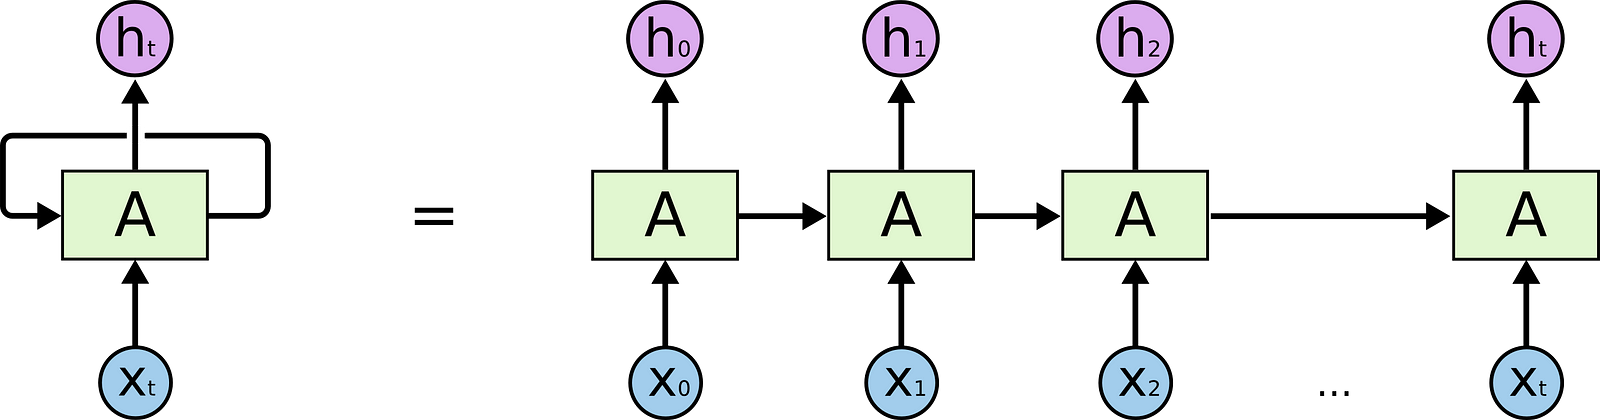

Ahora bien, aunque las RNN son bastante potentes, sufren el problema del gradiente evanescente, que les impide utilizar información a largo plazo; por ejemplo, son buenas para almacenar en la memoria 3 o 4 instancias de iteraciones pasadas, pero una mayor cantidad de instancias no proporciona buenos resultados, por lo que no utilizamos simplemente RNN normales. En su lugar, utilizamos una mejor variación de las RNN: redes de corto y largo plazo (LSTM).
¿Qué es el problema del gradiente evanescente?

El problema del gradiente evanescente es una dificultad que se encuentra en el entrenamiento de redes neuronales artificiales con métodos de aprendizaje basados ​​en gradientes y retropropagación. En dichos métodos, cada uno de los pesos de la red neuronal recibe una actualización proporcional a la derivada parcial de la función de error con respecto al peso actual en cada iteración de entrenamiento. El problema es que, en algunos casos, el gradiente será extremadamente pequeño, lo que impide de manera efectiva que el peso cambie su valor. En el peor de los casos, esto puede impedir por completo que la red neuronal continúe entrenándose. Como ejemplo de la causa del problema, las funciones de activación tradicionales, como la función tangente hiperbólica, tienen gradientes en el rango (0, 1), y la retropropagación calcula los gradientes mediante la regla de la cadena. Esto tiene el efecto de multiplicar n de estos números pequeños para calcular los gradientes de las capas "delanteras" en una red de n capas, lo que significa que el gradiente (señal de error) disminuye exponencialmente con n mientras las capas delanteras se entrenan muy lentamente.

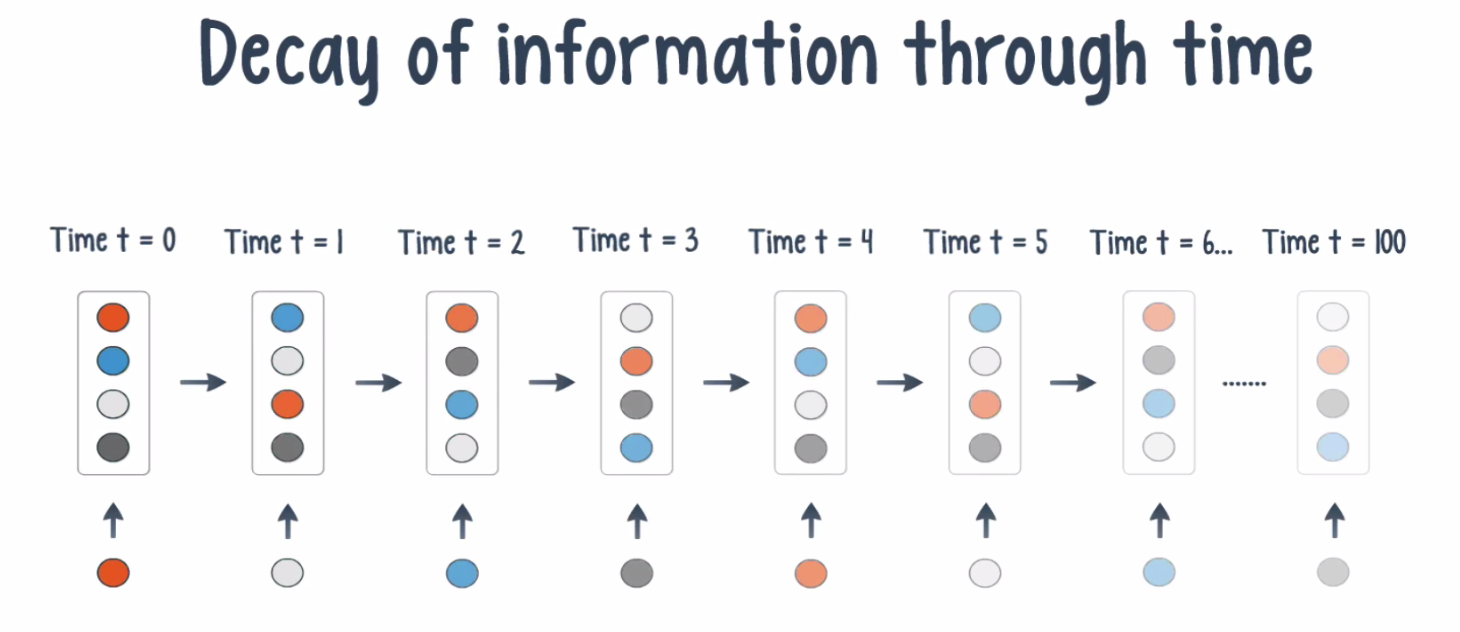

## Long Short Term Memory(LSTM)

Las unidades (o bloques) de memoria a largo plazo (LSTM) son una unidad de construcción para las capas de una red neuronal recurrente (RNN). Una RNN compuesta de unidades LSTM se suele denominar red LSTM. Una unidad LSTM común se compone de una celda, una puerta de entrada, una puerta de salida y una puerta de olvido. La celda es responsable de "recordar" valores en intervalos de tiempo arbitrarios; de ahí la palabra "memoria" en LSTM. Cada una de las tres puertas puede considerarse como una neurona artificial "convencional", como en una red neuronal multicapa (o de retroalimentación): es decir, calculan una activación (utilizando una función de activación) de una suma ponderada. Intuitivamente, pueden considerarse como reguladores del flujo de valores que pasan por las conexiones de la LSTM; de ahí la denominación "puerta". Hay conexiones entre estas puertas y la celda.

La expresión "largo plazo-corto plazo" se refiere al hecho de que LSTM es un modelo de memoria a corto plazo que puede durar un largo período de tiempo. Un LSTM es adecuado para clasificar, procesar y predecir series temporales dados desfases temporales de tamaño y duración desconocidos entre eventos importantes. Los LSTM se desarrollaron para abordar el problema del gradiente explosivo y evanescente al entrenar RNN tradicionales.

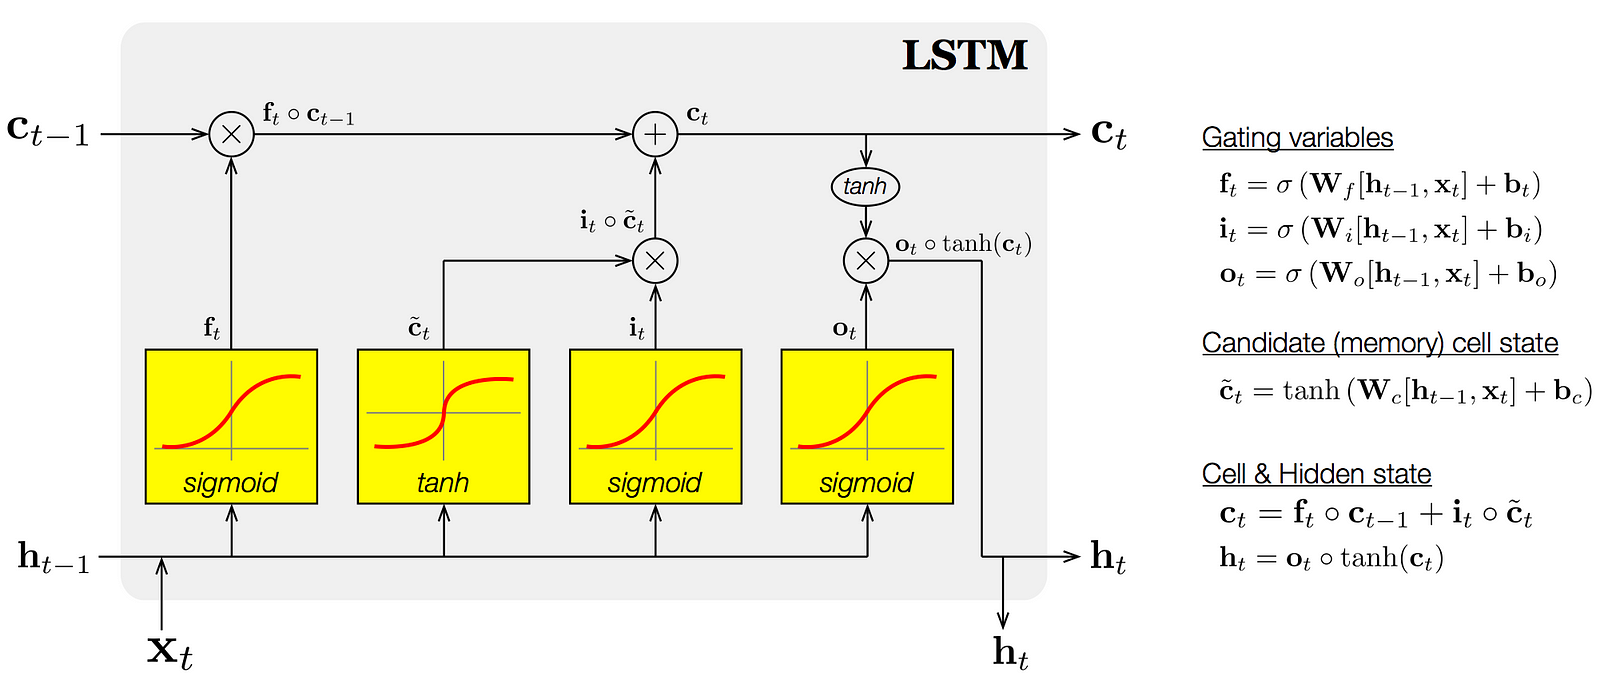

### Componentes de los LSTM

Por lo tanto, la celda LSTM contiene los siguientes componentes

* Puerta de olvido $f$ (una red neuronal con sigmoide)
* Capa candidata $C$ (una NN con Tanh)
* Puerta de entrada $I$ (una NN con sigmoide)
* Puerta de salida $O$ (una NN con sigmoide)
* Estado oculto $H$ (un vector)
* Estado de memoria $C$ (un vector)

Las entradas a la celda LSTM en cualquier paso son $X_t$ (entrada actual), $H_{t-1}$ (estado oculto anterior) y $C_{t-1}$ (estado de memoria anterior).
Las salidas de la celda LSTM son $H_t$ (estado oculto actual) y $C_t$ (estado de memoria actual)

### Funcionamiento de las puertas en los LSTM

Primero, la celda LSTM toma el estado de memoria anterior $C_{t-1}$ y realiza una multiplicación elemento por elemento con la puerta de olvido $(f)$ para decidir si el estado de memoria actual es $C_t$. Si el valor de la puerta de olvido es $0$, entonces el estado de memoria anterior se olvida por completo De lo contrario, si el valor de la puerta $f$ es $1$, el estado de memoria anterior se pasa por completo a la celda (la puerta $f$ proporciona valores entre $0$ y $1$).

$$C_t = C_{t-1} * f_t$$

Cálculo del nuevo estado de memoria:

$$C_t = C_t + (I_t * C_t)$$

Ahora, calculamos la salida:

$$H_t = \tanh(C_t)$$


## Vamos con código

In [18]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [19]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


In [20]:
# First, we get the data
dataset = pd.read_csv('https://raw.githubusercontent.com/alfredoandere/ML/refs/heads/master/Project1_DOJ30/stock-time-series-20050101-to-20171231/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [21]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

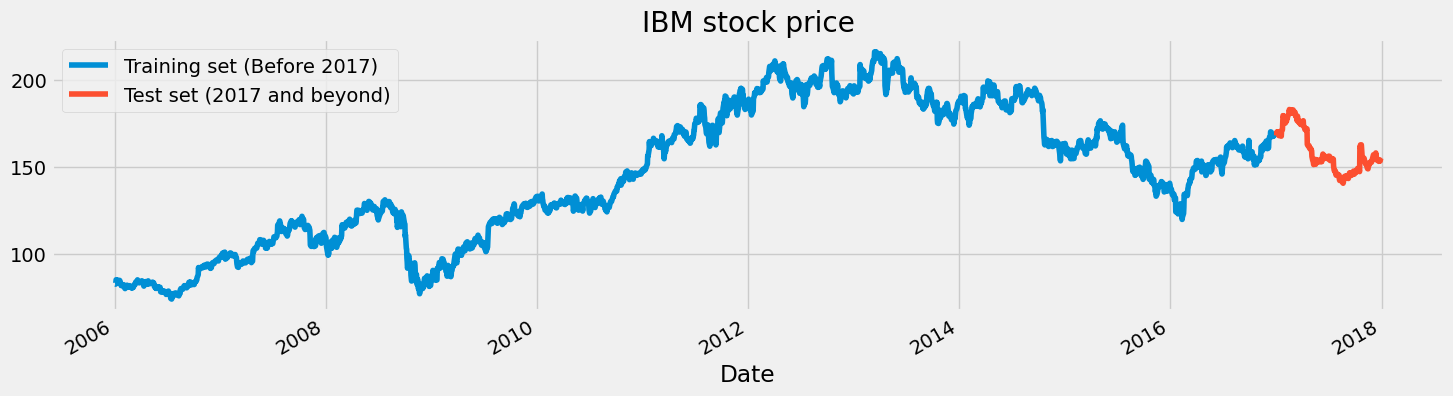

In [22]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [24]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

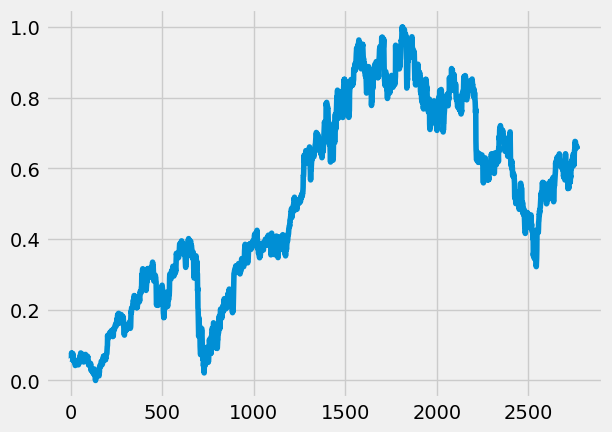

In [29]:
plt.plot(training_set_scaled)

In [33]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [35]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [38]:
#X_train

In [12]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - loss: 0.0425
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - loss: 0.0100
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - loss: 0.0092
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - loss: 0.0065
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - loss: 0.0070
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - loss: 0.0069
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - loss: 0.0052
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - loss: 0.0047
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - loss: 0.0051
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - loss: 0.0048
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 180ms/step - loss: 0.0037
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - loss: 0.0039
Epoch 13/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - loss: 0.0033
Epoch 14/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - loss: 0.0036
Epoch 15/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 

In [40]:
regressor.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 142,104 (555.10 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 71,053 (277.55 KB)

In [41]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [43]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


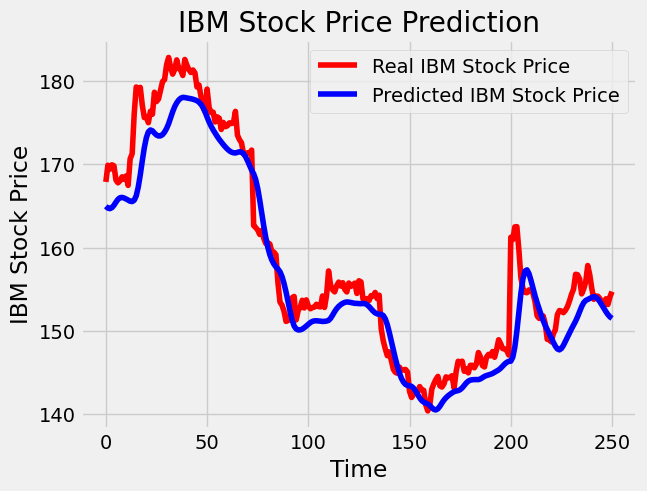

In [44]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [45]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 3.6482541085713462.


In [55]:
# Preparing sequence data
initial_sequence = X_train[2708,:]
sequence = []
for i in range(251):
    new_prediction = regressor.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

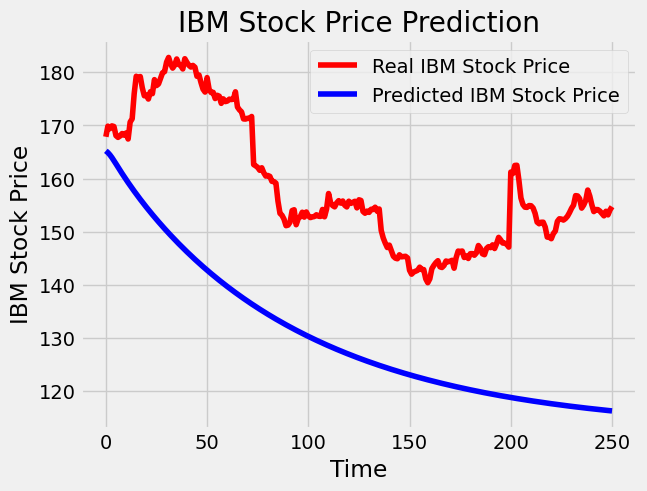

In [56]:
# Visualizing the sequence
plot_predictions(test_set,sequence)

In [57]:
# Evaluating the sequence
return_rmse(test_set,sequence)

The root mean squared error is 28.869132400270118.


LSTM no es el único tipo de unidad que ha tomado por asalto el mundo del aprendizaje profundo. Tenemos unidades recurrentes con compuertas (GRU). No se sabe cuál es mejor: GRU o LSTM porque tienen rendimientos comparables. Las GRU son más fáciles de entrenar que las LSTM.

## Unidades recurrentes con compuertas

En palabras simples, la unidad GRU no tiene que usar una unidad de memoria para controlar el flujo de información como la unidad LSTM. Puede hacer uso directo de todos los estados ocultos sin ningún control. Las GRU tienen menos parámetros y, por lo tanto, pueden entrenarse un poco más rápido o necesitar menos datos para generalizar. Pero, con datos grandes, las LSTM con mayor expresividad pueden generar mejores resultados.

Son casi similares a las LSTM, excepto que tienen dos compuertas: la compuerta de reinicio y la compuerta de actualización. La compuerta de reinicio determina cómo combinar la nueva entrada con la memoria anterior y la compuerta de actualización determina cuánto del estado anterior se debe conservar. La compuerta de actualización en GRU es lo que eran la compuerta de entrada y la compuerta de olvido en LSTM. No tenemos la segunda no linealidad en GRU antes de calcular la salida, ni tampoco tienen la puerta de salida.

In [48]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, weight_decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 372ms/step - loss: 0.1731
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - loss: 0.0698
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 329ms/step - loss: 0.0324
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - loss: 0.0075
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - loss: 0.0045
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - loss: 0.0037
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step - loss: 0.0036
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step - loss: 0.0036
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - loss: 0.0033
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 416ms/step - loss: 0.0030
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - loss: 0.0028
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 393ms/step - loss: 0.0028
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - loss: 0.0030
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - loss: 0.0028
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 271ms/ste

La versión actual utiliza una red GRU densa con 100 unidades a diferencia de la red GRU con 50 unidades de la versión anterior.

In [49]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step


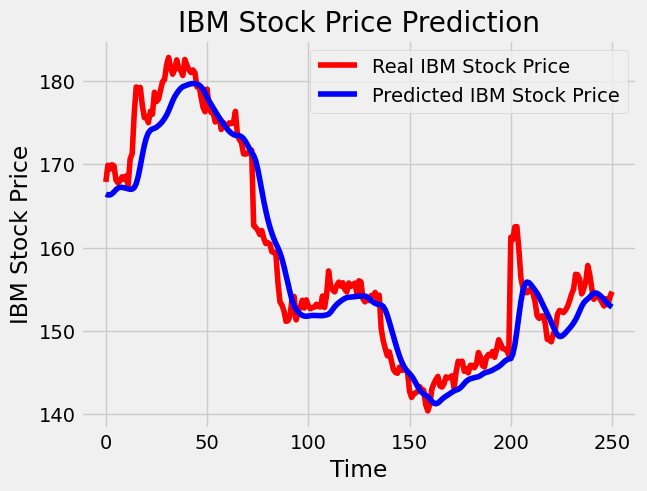

In [50]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [51]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.376512713196627.


## Generación de secuencias

Aquí, se genera una secuencia utilizando solo los 60 valores iniciales en lugar de utilizar los últimos 60 valores para cada nueva predicción. Debido a las dudas en varios comentarios sobre las predicciones que utilizan valores del conjunto de prueba, se decide incluir la generación de secuencias. Los modelos anteriores utilizan el conjunto de prueba, por lo que utilizan los últimos 60 valores verdaderos para predecir el nuevo valor. Es por eso que el error es tan bajo. Los modelos sólidos también pueden brindar resultados similares a los modelos anteriores para secuencias, pero requieren más que solo datos que tienen valores anteriores. En el caso de las acciones, necesitamos conocer los sentimientos del mercado, el movimiento de otras acciones y mucho más. Por lo tanto, no espere un gráfico remotamente preciso. El error será grande y lo mejor que puedo hacer es generar la tendencia similar al conjunto de prueba.

Se usa el modelo GRU para las predicciones. También puede intentar esto utilizando LSTM. He modificado el modelo GRU anterior para obtener la mejor secuencia posible. He ejecutado el modelo cuatro veces y en dos de ellas obtuve un error de entre 8 y 9. En el peor de los casos, el error fue de alrededor de 11. Veamos qué sucede con estas iteraciones.

El modelo GRU en las versiones anteriores también está bien. Solo se requirió un pequeño ajuste para obtener buenas secuencias. El objetivo principal de este núcleo es mostrar cómo construir modelos RNN. Cómo predecir los datos y qué tipo de datos predecir depende de usted. No puedo darle unas 100 líneas de código donde coloque el destino del conjunto de entrenamiento y prueba y obtenga resultados de primera clase. Eso es algo que debe hacer usted mismo.

In [52]:
# Preparing sequence data
initial_sequence = X_train[2708,:]
sequence = []
for i in range(251):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

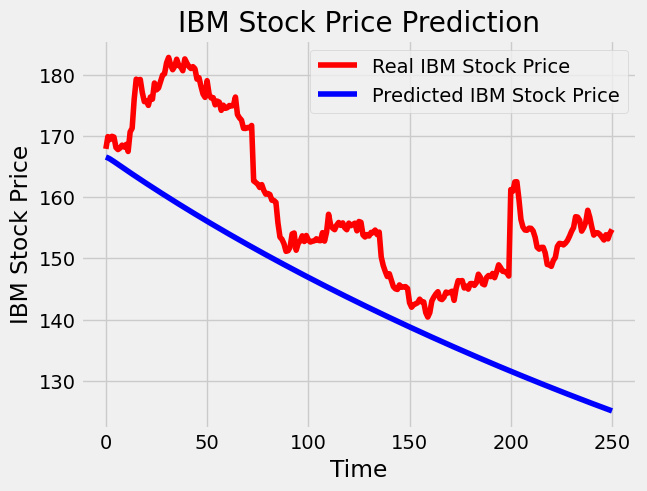

In [53]:
# Visualizing the sequence
plot_predictions(test_set,sequence)

In [54]:
# Evaluating the sequence
return_rmse(test_set,sequence)

The root mean squared error is 16.830668877253203.


Por lo tanto, GRU funciona mejor que LSTM en este caso. El LSTM bidireccional también es una buena manera de fortalecer el modelo. Pero esto puede variar para diferentes conjuntos de datos. La aplicación conjunta de LSTM y GRU dio resultados aún mejores.